In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime

data = pd.read_csv('/content/gdrive/My Drive/capstone1/data.csv')
data.head()
# print(data.iloc[0,1])

,구분,일시,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,당진매립장태양광,2017-07-01,0,0,0,0,0,0,24,86,147,161,509,546,372,257,107,70,15,2,0,0,0,0,0,0
1,당진매립장태양광,2017-07-02,0,0,0,0,0,0,0,48,99,129,210,243,72,80,170,155,39,7,0,0,0,0,0,0
2,당진매립장태양광,2017-07-03,0,0,0,0,0,0,1,47,83,288,397,273,409,84,21,91,150,118,0,0,0,0,0,0
3,당진매립장태양광,2017-07-04,0,0,0,0,0,0,24,75,170,436,553,698,713,717,684,543,397,240,103,12,0,0,0,0
4,당진매립장태양광,2017-07-05,0,0,0,0,0,0,28,103,172,285,448,607,653,648,645,573,454,276,94,6,0,0,0,0


In [3]:
def reshape_data(data):
    reshape_data = pd.DataFrame(columns=['dt', 'generation_amount'])
    for index in data.index:
        for hour in range(7, 20):
            dt = datetime.datetime.strptime(data.iloc[index, 1], '%Y-%m-%d') + datetime.timedelta(hours=hour)
            reshape_data.loc[24*index + hour - 7] = [dt, data.iloc[index, 1+hour]]
    data = reshape_data['generation_amount']
    data.index = reshape_data['dt']
    return data

In [4]:
origin_data = reshape_data(data)
print(origin_data)

dt
2017-07-01 07:00:00     24
2017-07-01 08:00:00     86
2017-07-01 09:00:00    147
2017-07-01 10:00:00    161
2017-07-01 11:00:00    509
                      ... 
2020-07-26 15:00:00     90
2020-07-26 16:00:00    261
2020-07-26 17:00:00    153
2020-07-26 18:00:00     77
2020-07-26 19:00:00     40
Name: generation_amount, Length: 14482, dtype: object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f134ad00cf8>],
      dtype=object)

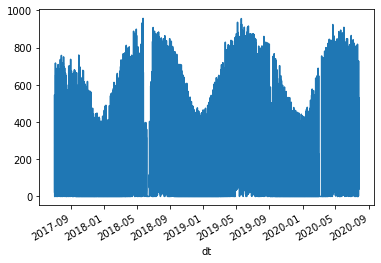

In [5]:
origin_data.plot(subplots=True)

In [6]:
train_size = 10500

data = origin_data.values
data_mean = data[:train_size].mean()
data_std = data[:train_size].std()
data = (data - data_mean)/data_std

In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [9]:
past_history = 20
future_target = 0

x_train, y_train = univariate_data(data, 0, train_size, past_history, future_target)
x_val, y_val = univariate_data(data, train_size, None, past_history, future_target)

In [10]:
print('single window of past history')
print(x_train[0])
print('target generation amount to predict')
print(y_train[0])

single window of past history
[[-0.97872215]
 [-0.7286222 ]
 [-0.48255613]
 [-0.42608195]
 [ 0.97770485]
 [ 1.12695804]
 [ 0.42506464]
 [-0.03883042]
 [-0.64391093]
 [-0.79316413]
 [-1.01502698]
 [-1.06746729]
 [-1.07553503]
 [-1.07553503]
 [-0.88190927]
 [-0.67618189]
 [-0.55516579]
 [-0.22842231]
 [-0.0953046 ]
 [-0.78509639]]
target generation amount to predict
-0.7528254253327945


In [11]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['history', 'true future', 'model prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

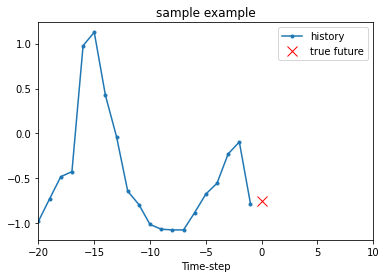

In [12]:
show_plot([x_train[0], y_train[0]], 0, 'sample example')

In [13]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

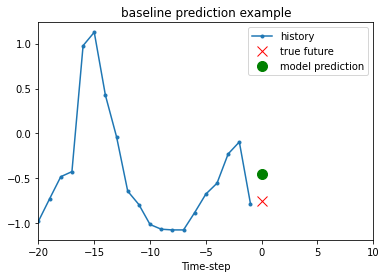

In [14]:
show_plot([x_train[0], y_train[0], baseline(x_train[0])], 0, 'baseline prediction example')

In [15]:
batch_size = 256
buffer_size = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(batch_size).repeat()

In [16]:
simple_lstm_model = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(1)]
     )

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [17]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [18]:
evaluation_interval = 200
epochs = 50

simple_lstm_model.fit(train_univariate, epochs=epochs, steps_per_epoch=evaluation_interval,
                    validation_data=val_univariate, validation_steps=50)

Epoch 1/50
200/200 [==============================] - 1s 6ms/step - loss: 0.8262 - val_loss: 0.5662
Epoch 2/50
200/200 [==============================] - 1s 5ms/step - loss: 0.4206 - val_loss: 0.2779
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2404 - val_loss: 0.1935
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2082 - val_loss: 0.1819
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2017 - val_loss: 0.1794
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1989 - val_loss: 0.1762
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1964 - val_loss: 0.1749
Epoch 8/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1951 - val_loss: 0.1730
Epoch 9/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1938 - val_loss: 0.1731
Epoch 10/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1928 - val_loss: 0.1710

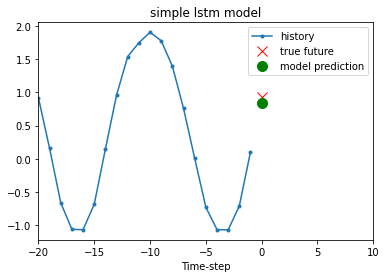

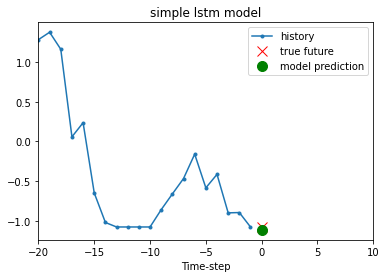

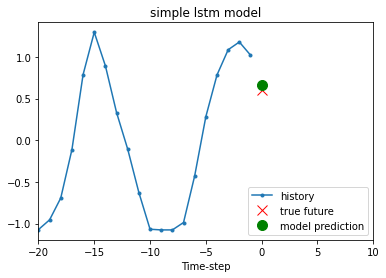

In [19]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0 ,'simple lstm model')
    plot.show()

In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [75]:
past_history = 240
future_target = 24
step = 6

dataset = origin_data.values
data_mean = dataset[:train_size].mean(axis=0)
data_std = dataset[:train_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:], 0, 
                                                 train_size, past_history, 
                                                 future_target, step)
x_train_multi = x_train_multi.reshape(-1, 40, 1)
y_train_multi = y_train_multi.reshape(-1, 24, 1)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:], train_size, 
                                             None, past_history, future_target, step)
x_val_multi = x_val_multi.reshape(-1, 40, 1)
y_val_multi = y_val_multi.reshape(-1, 24, 1)
print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

(10260, 40, 1) (10260, 24, 1) (3718, 40, 1) (3718, 24, 1)


In [76]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [77]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='history')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'b-', label='true future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'r-', label='predicted future')
    plt.legend(loc='upper left')
    plt.show()

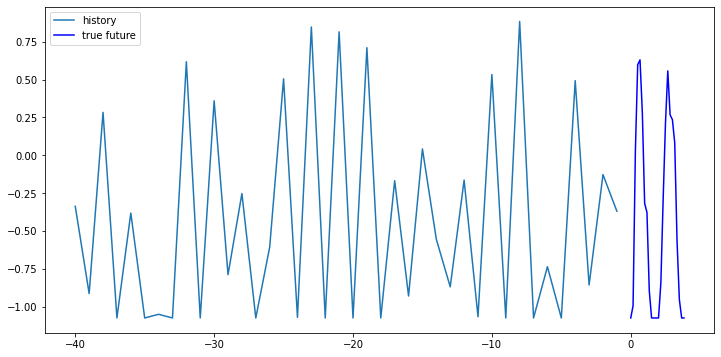

In [78]:

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [68]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [79]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 24)


In [98]:
with tf.device('/device:GPU:0'):
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(40, 1)))
    multi_step_model.add(tf.keras.layers.LSTM(16, recurrent_activation='sigmoid'))
    multi_step_model.add(tf.keras.layers.Dense(24))

    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [99]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=15,
                                          steps_per_epoch=evaluation_interval,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
200/200 [==============================] - 2s 11ms/step - loss: 0.7976 - val_loss: 0.7579
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 0.7364 - val_loss: 0.6136
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 0.5782 - val_loss: 0.4649
Epoch 4/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4652 - val_loss: 0.4100
Epoch 5/15
200/200 [==============================] - 2s 9ms/step - loss: 0.4380 - val_loss: 0.4007
Epoch 6/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4286 - val_loss: 0.3873
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4221 - val_loss: 0.3956
Epoch 8/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4168 - val_loss: 0.3869
Epoch 9/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4121 - val_loss: 0.3845
Epoch 10/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4078 - val_loss: 0.390

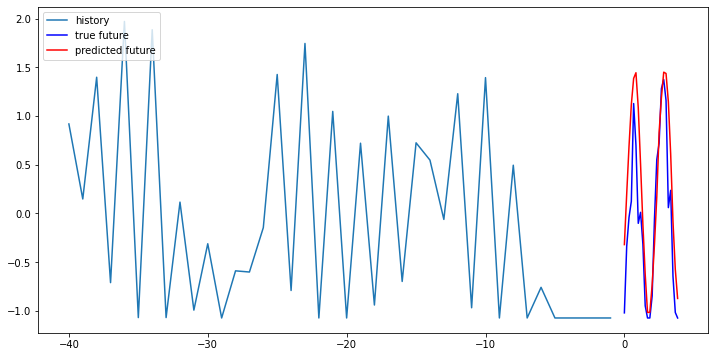

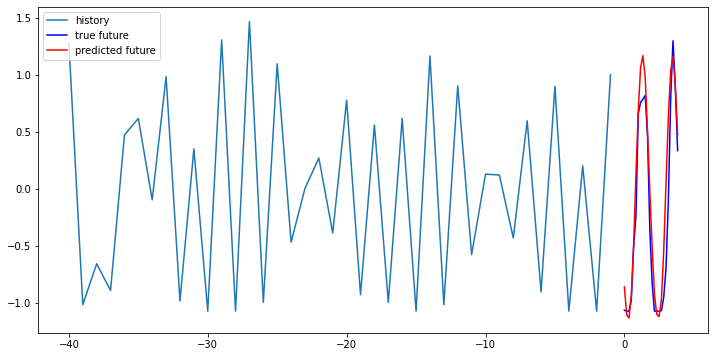

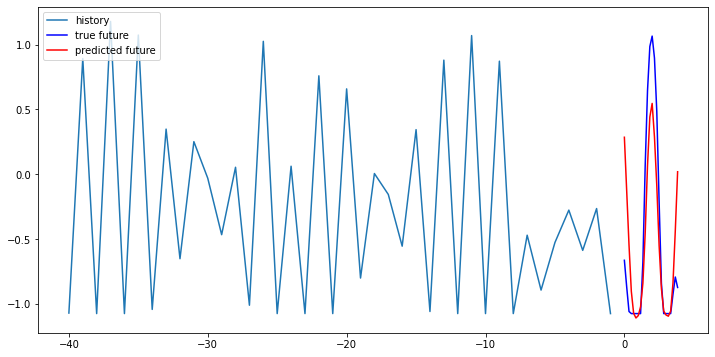

In [106]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])